# Administrative Geographic Hierarchy

This notebook creates a **relational table** linking Spanish municipalities to their
corresponding administrative units at multiple territorial scales:

- **Municipality** (*Municipio*)
- **Province** (*Provincia*)
- **Autonomous Community** (*Comunidad Autónoma*)
- **Agricultural Region** (*Comarca Agraria*) - optional

This hierarchical reference table enables spatial aggregation and multi-scale analysis
across different administrative levels, and will be used to join demographic,
agricultural, and land-use datasets in subsequent analytical workflows.

The table is exported as a standalone CSV file to ensure methodological clarity,
traceability, and reproducibility.

## Methodology

**Province and CCAA assignment** is extracted directly from the **NATCODE** field in
municipal shapefiles, which follows this structure:

### NATCODE Structure (11 digits):
```
34 07 09 09298
│  │  │  └───── Municipality code (5 digits)
│  │  └──────── Province code (2 digits)
│  └─────────── Autonomous Community code (2 digits)
└────────────── Country code (34 = Spain) - MUST BE SKIPPED
```

**Important:** The first 2 digits (34) represent the country code for Spain and must be
removed before extracting CCAA, Province, and Municipality codes.

Example: `34070909298`
- Country: `34` (skip this)
- CCAA: `07` (Castilla y León)
- Province: `09` (Burgos)
- Municipality: `09298`

### Official INE Administrative Units:
- **Municipalities:** 8,132
- **Provinces:** 52 (50 provinces + Ceuta + Melilla)
- **Autonomous Communities:** 19 (17 CCAA + Ceuta + Melilla)

### Data Cleaning:
The CNIG shapefiles include non-municipality territories that must be excluded:
- Gibraltar (not Spanish territory)
- Plazas de soberanía (sovereignty territories with no civilian population)

**Agricultural Region** assignment is performed via spatial join with MAPA comarcas layer.
This is optional and may not cover 100% of municipalities.

**Data Sources:**
- Municipal boundaries: CNIG - https://centrodedescargas.cnig.es/CentroDescargas/
- Agricultural regions: MAPA - https://www.mapa.gob.es/es/cartografia-y-sig/ide/descargas/agricultura

In [1]:
"""
Notebook: 00_geographic_administrative_hierarchy.ipynb
Purpose: Create relational table linking municipalities to administrative units
Input: CNIG municipal boundaries, MAPA agricultural regions (optional)
Output: geographic_administrative_hierarchy.csv
Author: Juan Zotes
Last updated: 2026-02-04
"""

'\nNotebook: 00_geographic_administrative_hierarchy.ipynb\nPurpose: Create relational table linking municipalities to administrative units\nInput: CNIG municipal boundaries, MAPA agricultural regions (optional)\nOutput: geographic_administrative_hierarchy.csv\nAuthor: Juan Zotes\nLast updated: 2026-02-04\n'

## 1. Load required libraries and configure environment

In [2]:
# Standard library
from pathlib import Path
import warnings

# Third-party libraries
import pandas as pd
import geopandas as gpd

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

In [3]:
# Base data directory (portable across Windows, Linux, Codespaces)
DATA_DIR = Path(
    r"/workspaces/rural-migration-land-use-spain/data"
)

# Spatial data directory
SPATIAL_DIR = Path(
    r"/workspaces/rural-migration-land-use-spain/data/spatial/raw"
)

# Ensure directories exist
DATA_DIR.mkdir(parents=True, exist_ok=True)
SPATIAL_DIR.mkdir(parents=True, exist_ok=True)

print(f"Data directory: {DATA_DIR}")
print(f"Spatial directory: {SPATIAL_DIR}")

Data directory: /workspaces/rural-migration-land-use-spain/data
Spatial directory: /workspaces/rural-migration-land-use-spain/data/spatial/raw


## 2. Configure shapefile paths and verify files

**Required shapefiles:**

| Layer | Peninsula + Baleares | Canarias |
|-------|---------------------|----------|
| Municipalities | `recintos_municipales_inspire_peninbal_etrs89.shp` | `recintos_municipales_inspire_canarias_regcan95.shp` |
| Provinces | `recintos_provinciales_inspire_peninbal_etrs89.shp` | `recintos_provinciales_inspire_canarias_regcan95.shp` |
| CCAA | `recintos_autonomicas_inspire_peninbal_etrs89.shp` | `recintos_autonomicas_inspire_canarias_regcan95.shp` |

**Optional:** `ComarcasAgrarias.shp` (Agricultural regions from MAPA)

**Source:** CNIG - https://centrodedescargas.cnig.es/CentroDescargas/home

In [4]:
# Define shapefile paths
municipalities_peninsula_shp = SPATIAL_DIR / "recintos_municipales_inspire_peninbal_etrs89.shp"
municipalities_canarias_shp = SPATIAL_DIR / "recintos_municipales_inspire_canarias_regcan95.shp"
provinces_peninsula_shp = SPATIAL_DIR / "recintos_provinciales_inspire_peninbal_etrs89.shp"
provinces_canarias_shp = SPATIAL_DIR / "recintos_provinciales_inspire_canarias_regcan95.shp"
ccaa_peninsula_shp = SPATIAL_DIR / "recintos_autonomicas_inspire_peninbal_etrs89.shp"
ccaa_canarias_shp = SPATIAL_DIR / "recintos_autonomicas_inspire_canarias_regcan95.shp"
comarcas_shp = SPATIAL_DIR / "ComarcasAgrarias.shp"

# Verify required files exist
required_files = {
    "Municipalities (Peninsula)": municipalities_peninsula_shp,
    "Municipalities (Canarias)": municipalities_canarias_shp,
    "Provinces (Peninsula)": provinces_peninsula_shp,
    "Provinces (Canarias)": provinces_canarias_shp,
    "Autonomous Communities (Peninsula)": ccaa_peninsula_shp,
    "Autonomous Communities (Canarias)": ccaa_canarias_shp
}

optional_files = {
    "Agricultural Regions": comarcas_shp
}

print("=== Checking required shapefiles ===")
all_found = True
for name, path in required_files.items():
    if path.exists():
        print(f"✓ {name}: Found")
    else:
        print(f"✗ {name}: NOT FOUND")
        print(f"  Expected at: {path}")
        all_found = False

print("\n=== Checking optional shapefiles ===")
for name, path in optional_files.items():
    if path.exists():
        print(f"✓ {name}: Found")
    else:
        print(f"○ {name}: Not found (optional)")

if all_found:
    print("\n✓ All required shapefiles found. Ready to proceed.")
else:
    print("\n⚠ Some required shapefiles are missing.")

=== Checking required shapefiles ===
✓ Municipalities (Peninsula): Found
✓ Municipalities (Canarias): Found
✓ Provinces (Peninsula): Found
✓ Provinces (Canarias): Found
✓ Autonomous Communities (Peninsula): Found
✓ Autonomous Communities (Canarias): Found

=== Checking optional shapefiles ===
✓ Agricultural Regions: Found

✓ All required shapefiles found. Ready to proceed.


In [5]:
# Common CRS for all layers (ETRS89 - EPSG:4258)
# This geographic CRS covers all of Spain (Peninsula, Baleares, Canarias)
TARGET_CRS = "EPSG:4258"

print(f"Target CRS: {TARGET_CRS} (ETRS89)")

Target CRS: EPSG:4258 (ETRS89)


In [6]:
# Configuration: Include agricultural regions (comarcas agrarias)
INCLUDE_COMARCAS = True

print(f"Agricultural regions: {'ENABLED' if INCLUDE_COMARCAS else 'DISABLED'}")

Agricultural regions: ENABLED


In [7]:
# Load agricultural regions (comarcas)
# Note: The comarca -> prov/CCAA lookup will be built AFTER spatial join
# using the municipalities that fall within each comarca

if INCLUDE_COMARCAS and comarcas_shp.exists():
    print("Loading agricultural regions (comarcas)...")
    gdf_comarca = gpd.read_file(comarcas_shp)
    gdf_comarca = gdf_comarca.to_crs(TARGET_CRS)
    
    # Extract comarca info
    comarca_name_col = 'DS_COMARCA' if 'DS_COMARCA' in gdf_comarca.columns else 'NAMEUNIT'
    comarca_code_col = 'CO_COMARCA' if 'CO_COMARCA' in gdf_comarca.columns else None
    
    gdf_comarca['Comarca_Name'] = gdf_comarca[comarca_name_col]
    if comarca_code_col:
        gdf_comarca['Comarca_Code'] = gdf_comarca[comarca_code_col]
    
    print(f"   Loaded {len(gdf_comarca)} comarcas")
    print(f"   Note: Comarca -> Prov/CCAA lookup will be built after spatial join")
    
elif INCLUDE_COMARCAS:
    print(f"⚠ Comarcas shapefile not found: {comarcas_shp}")
    INCLUDE_COMARCAS = False
    gdf_comarca = None
else:
    print("Skipping comarcas (INCLUDE_COMARCAS = False)")
    gdf_comarca = None


Loading agricultural regions (comarcas)...
   Loaded 356 comarcas
   Note: Comarca -> Prov/CCAA lookup will be built after spatial join


## 3. Load and merge municipal boundaries

Municipal boundaries are loaded from Peninsula and Canary Islands shapefiles,
reprojected to ETRS89 (EPSG:4258), and merged.

**Note:** The raw data includes non-municipality territories that will be filtered later.

In [8]:
# Load Peninsula + Balearic Islands municipalities
print("Loading municipalities (Peninsula + Balearic Islands)...")
gdf_mun_peninsula = gpd.read_file(municipalities_peninsula_shp)
gdf_mun_peninsula = gdf_mun_peninsula.to_crs(TARGET_CRS)

print(f"   Loaded {len(gdf_mun_peninsula)} municipalities")

Loading municipalities (Peninsula + Balearic Islands)...
   Loaded 8132 municipalities


In [9]:
# Load Canary Islands municipalities
print("Loading municipalities (Canary Islands)...")
gdf_mun_canarias = gpd.read_file(municipalities_canarias_shp)
gdf_mun_canarias = gdf_mun_canarias.to_crs(TARGET_CRS)

print(f"   Loaded {len(gdf_mun_canarias)} municipalities")

Loading municipalities (Canary Islands)...
   Loaded 88 municipalities


In [10]:
# Merge both municipality datasets
print("Merging Peninsula and Canarias municipalities...")
gdf_mun = pd.concat([gdf_mun_peninsula, gdf_mun_canarias], ignore_index=True)

print(f"   Total municipalities: {len(gdf_mun)}")
print(f"\nSample NATCODE structure:")
print(gdf_mun[['NATCODE', 'NAMEUNIT']].head())


Merging Peninsula and Canarias municipalities...
   Total municipalities: 8220

Sample NATCODE structure:
       NATCODE                NAMEUNIT
0  34070909298  Quintanilla San García
1  34070909301       Quintanilla Vivar
2  34070909302      Rabanera del Pinar
3  34070505105        Hoyos del Espino
4  34070505106   Hoyos de Miguel Muñoz


In [11]:
# VALIDATION: Check raw municipality count against INE official figure
# This assert is EXPECTED TO FAIL - demonstrates that raw data needs cleaning
# INE_MUNICIPALITIES = 8132

try:
    assert len(gdf_mun) == 8132, f"Expected 8,132 municipalities, got {len(gdf_mun)}"
except AssertionError as e:
    print(f"⚠ EXPECTED FAILURE: {e}")
    print(f"   → This confirms raw data includes non-municipality territories")

⚠ EXPECTED FAILURE: Expected 8,132 municipalities, got 8220
   → This confirms raw data includes non-municipality territories


## 4. Extract administrative codes from NATCODE

**CRITICAL:** The NATCODE field contains a country code prefix (34 = Spain) that must
be removed before extracting administrative codes.

### Extraction logic:
```
Position:  0-1   2-3  4-5  6-10
Example:   34     07   09   09298
Meaning: Country CCAA Prov Municipality
```

1. Remove 'ES' prefix if present
2. Skip first 2 digits (country code: 34)
3. Extract:
   - CCAA_Code: positions [2:4]
   - Prov_Code: positions [4:6]
   - Mun_Code: last 5 digits [-5:]

In [12]:
# Clean NATCODE: remove 'ES' prefix if present
gdf_mun['NATCODE_str'] = gdf_mun['NATCODE'].astype(str).str.replace('ES', '', regex=False)

# Extract codes: SKIP first 2 digits (country code 34)
gdf_mun['CCAA_Code'] = gdf_mun['NATCODE_str'].str[2:4]   # Digits 3-4
gdf_mun['Prov_Code'] = gdf_mun['NATCODE_str'].str[4:6]   # Digits 5-6
gdf_mun['Mun_Code'] = gdf_mun['NATCODE_str'].str[-5:]    # Last 5 digits
gdf_mun['Mun_Name'] = gdf_mun['NAMEUNIT']

print("Codes extracted from NATCODE:")
print(gdf_mun[['NATCODE', 'NATCODE_str', 'CCAA_Code', 'Prov_Code', 'Mun_Code', 'Mun_Name']].head(10))

Codes extracted from NATCODE:
       NATCODE  NATCODE_str CCAA_Code Prov_Code Mun_Code  \
0  34070909298  34070909298        07        09    09298   
1  34070909301  34070909301        07        09    09301   
2  34070909302  34070909302        07        09    09302   
3  34070505105  34070505105        07        05    05105   
4  34070505106  34070505106        07        05    05106   
5  34070505107  34070505107        07        05    05107   
6  34070505108  34070505108        07        05    05108   
7  34070505109  34070505109        07        05    05109   
8  34070505114  34070505114        07        05    05114   
9  34070505116  34070505116        07        05    05116   

                       Mun_Name  
0        Quintanilla San García  
1             Quintanilla Vivar  
2            Rabanera del Pinar  
3              Hoyos del Espino  
4         Hoyos de Miguel Muñoz  
5                 Hurtumpascual  
6                      Junciana  
7                         Langa  
8  

## 5. Load provinces and create lookup table

Province shapefiles are used to create a lookup table mapping:
- `CCAA_Code` + `Prov_Code` → `Prov_Name`

**Expected count before filtering:** 55 (includes "Territorios no asociados")

In [13]:
# Load Peninsula + Balearic Islands provinces
print("Loading provinces (Peninsula + Balearic Islands)...")
gdf_prov_peninsula = gpd.read_file(provinces_peninsula_shp)
gdf_prov_peninsula = gdf_prov_peninsula.to_crs(TARGET_CRS)

print(f"   Loaded {len(gdf_prov_peninsula)} provinces")

Loading provinces (Peninsula + Balearic Islands)...
   Loaded 53 provinces


In [14]:
# Load Canary Islands provinces
print("Loading provinces (Canary Islands)...")
gdf_prov_canarias = gpd.read_file(provinces_canarias_shp)
gdf_prov_canarias = gdf_prov_canarias.to_crs(TARGET_CRS)

print(f"   Loaded {len(gdf_prov_canarias)} provinces")

Loading provinces (Canary Islands)...
   Loaded 2 provinces


In [15]:
# Merge provinces
gdf_prov = pd.concat([gdf_prov_peninsula, gdf_prov_canarias], ignore_index=True)

print(f"Total provinces: {len(gdf_prov)}")

# Assert: Before filtering, we expect 55 (includes "Territorios no asociados")
assert len(gdf_prov) == 55, f"Expected 55 provinces before filtering, got {len(gdf_prov)}"

Total provinces: 55


In [16]:
# VALIDATION: Check raw municipality count against INE official figure
# This assert is EXPECTED TO FAIL - demonstrates that raw data needs cleaning
# PROVINCES = 50 + 2 autonomous cities

try:
    assert len(gdf_prov) == 52, f"Expected 52 provinces, got {len(gdf_prov)}"
except AssertionError as e:
    print(f"⚠ EXPECTED FAILURE: {e}")
    print(f"   → This confirms raw data includes non-province territories")

⚠ EXPECTED FAILURE: Expected 52 provinces, got 55
   → This confirms raw data includes non-province territories


In [17]:
# Extract province codes from NATCODE (skip first 2 digits = country code)
gdf_prov['NATCODE_str'] = gdf_prov['NATCODE'].astype(str).str.replace('ES', '', regex=False)
gdf_prov['CCAA_Code'] = gdf_prov['NATCODE_str'].str[2:4]  # Digits 3-4
gdf_prov['Prov_Code'] = gdf_prov['NATCODE_str'].str[4:6]  # Digits 5-6
gdf_prov['Prov_Name'] = gdf_prov['NAMEUNIT']

# Create province lookup table
prov_lookup = gdf_prov[['CCAA_Code', 'Prov_Code', 'Prov_Name']].drop_duplicates()

print(f"Province lookup table: {len(prov_lookup)} unique provinces")
print("\nSample:")
print(prov_lookup.head(10))

Province lookup table: 54 unique provinces

Sample:
  CCAA_Code Prov_Code         Prov_Name
0        16        01       Araba/Álava
1        08        02          Albacete
2        10        03  Alacant/Alicante
3        01        04           Almería
4        07        05             Ávila
5        11        06           Badajoz
6        04        07     Illes Balears
7        09        08         Barcelona
8        07        09            Burgos
9        11        10           Cáceres


In [18]:
# Check last provinces (including "Territorios no asociados")
print("Last 10 provinces (including territories to be filtered):")
print(prov_lookup.tail(10))

Last 10 provinces (including territories to be filtered):
   CCAA_Code Prov_Code                                          Prov_Name
44        07        47                                         Valladolid
45        16        48                                            Bizkaia
46        07        49                                             Zamora
47        02        50                                           Zaragoza
48        18        51                                              Ceuta
49        19        52                                            Melilla
50        20        54       Territorios no asociados a ninguna provincia
52        20        54  Gibraltar. Territorio no asociado a ninguna pr...
53        05        35                                         Las Palmas
54        05        38                             Santa Cruz de Tenerife


## 6. Load autonomous communities and create lookup table

CCAA shapefiles are used to create a lookup table mapping:
- `CCAA_Code` → `CCAA_Name`

**Expected count before filtering:** 22 (includes "Territorios no asociados")

In [19]:
# Load Peninsula + Balearic Islands autonomous communities
print("Loading autonomous communities (Peninsula + Balearic Islands)...")
gdf_ccaa_peninsula = gpd.read_file(ccaa_peninsula_shp)
gdf_ccaa_peninsula = gdf_ccaa_peninsula.to_crs(TARGET_CRS)

print(f"   Loaded {len(gdf_ccaa_peninsula)} autonomous communities")

Loading autonomous communities (Peninsula + Balearic Islands)...
   Loaded 21 autonomous communities


In [20]:
# Load Canary Islands autonomous community
print("Loading autonomous communities (Canary Islands)...")
gdf_ccaa_canarias = gpd.read_file(ccaa_canarias_shp)
gdf_ccaa_canarias = gdf_ccaa_canarias.to_crs(TARGET_CRS)

print(f"   Loaded {len(gdf_ccaa_canarias)} autonomous communities")

Loading autonomous communities (Canary Islands)...
   Loaded 1 autonomous communities


In [21]:
# Merge CCAA
gdf_ccaa = pd.concat([gdf_ccaa_peninsula, gdf_ccaa_canarias], ignore_index=True)

print(f"Total autonomous communities: {len(gdf_ccaa)}")

# Assert: Before filtering, we expect 22 (includes "Territorios no asociados")
assert len(gdf_ccaa) == 22, f"Expected 22 CCAA before filtering, got {len(gdf_ccaa)}"

Total autonomous communities: 22


In [22]:
# Extract CCAA codes from NATCODE (skip first 2 digits = country code)
gdf_ccaa['NATCODE_str'] = gdf_ccaa['NATCODE'].astype(str).str.replace('ES', '', regex=False)
gdf_ccaa['CCAA_Code'] = gdf_ccaa['NATCODE_str'].str[2:4]  # Digits 3-4
gdf_ccaa['CCAA_Name'] = gdf_ccaa['NAMEUNIT']

# Create CCAA lookup table
ccaa_lookup = gdf_ccaa[['CCAA_Code', 'CCAA_Name']].drop_duplicates()

print(f"CCAA lookup table: {len(ccaa_lookup)} unique autonomous communities")
print("\nComplete list:")
print(ccaa_lookup.sort_values('CCAA_Code').to_string())

CCAA lookup table: 21 unique autonomous communities

Complete list:
   CCAA_Code                                              CCAA_Name
0         01                                              Andalucía
1         02                                                 Aragón
2         03                                 Principado de Asturias
3         04                                          Illes Balears
21        05                                               Canarias
4         06                                              Cantabria
5         07                                        Castilla y León
6         08                                     Castilla-La Mancha
7         09                                     Cataluña/Catalunya
8         10                                   Comunitat Valenciana
9         11                                            Extremadura
10        12                                                Galicia
11        13                                    

In [23]:
# VALIDATION: Check raw municipality count against INE official figure
# This assert is EXPECTED TO FAIL - demonstrates that raw data needs cleaning
# PROVINCES = 50 + 2 autonomous cities

try:
    assert len(gdf_ccaa) == 19, f"Expected 19 CCAA, got {len(gdf_ccaa)}"
except AssertionError as e:
    print(f"⚠ EXPECTED FAILURE: {e}")
    print(f"   → This confirms raw data includes non-CCAA territories")

⚠ EXPECTED FAILURE: Expected 19 CCAA, got 22
   → This confirms raw data includes non-CCAA territories


## 7. Filter non-municipality territories

The CNIG shapefiles include territories that are **NOT official municipalities**
according to INE (Instituto Nacional de Estadística):

- **Gibraltar** (not Spanish territory)
- **Plazas de soberanía** (sovereignty territories with no civilian population):
  - Isla del Perejil (54001)
  - Peñón de Vélez de la Gomera (54002)
  - Islas Chafarinas (54003)
  - Islas Alhucemas (54004)
  - Peñón de Alhucemas (54005)
  - Gibraltar (54006)

These all have Province/CCAA code **54** = "Territorios no asociados"

### Expected counts after filtering:
- Municipalities: **8,132**
- Provinces: **52** (50 provinces + Ceuta + Melilla)
- Autonomous Communities: **19** (17 CCAA + Ceuta + Melilla)

In [24]:
# ==============================================================================
# EXTRACT NON-MUNICIPALITY TERRITORIES (for separate analysis)
# ==============================================================================
# Before filtering, we extract all territories with code >= 53000.
# These are shared land management entities (mancomunidades, parzonerías, 
# facerías, comunidades) that may be useful for other parts of the analysis.
#
# This list is saved for reference before these territories are removed
# from the main municipality dataset.
# ==============================================================================

# ------------------------------------------------------------------------------
# PREPARE NON-MUNICIPAL TERRITORIES
# ------------------------------------------------------------------------------

gdf_mun["Mun_Code_int"] = gdf_mun["Mun_Code"].astype(int)

non_municipalities = gdf_mun[gdf_mun["Mun_Code_int"] >= 53000].copy()

shared_land = non_municipalities[
    (non_municipalities["Mun_Code_int"] >= 53000) &
    (non_municipalities["Mun_Code_int"] < 54000)
].copy()

special_territories = non_municipalities[
    non_municipalities["Mun_Code_int"] >= 54000
].copy()

# Dictionary: municipality code -> name
mun_dict = (
    gdf_mun[gdf_mun["Mun_Code_int"] < 53000]
    .set_index("Mun_Code_int")["Mun_Name"]
    .to_dict()
)


In [25]:
import re

def replace_codes_with_names(text, mun_dict):
    if not isinstance(text, str):
        return text
    codes = re.findall(r"\b\d{5}\b", text)
    for code in codes:
        code_int = int(code)
        if code_int in mun_dict:
            text = text.replace(code, mun_dict[code_int])
    return text

shared_land["Mun_Name_clean"] = shared_land["Mun_Name"].apply(
    lambda x: replace_codes_with_names(x, mun_dict)
)


In [26]:
# ==============================================================================
# NON-MUNICIPAL ENTITIES (INSPECTION BEFORE MAPPING)
# ==============================================================================

print("\n" + "="*70)
print("NON-MUNICIPAL ENTITIES (codes >= 53000)")
print("="*70)

print(f"\nTotal non-municipal entities: {len(non_municipalities)}\n")

# ------------------------------------------------------------------
# SHARED LAND ENTITIES (53xxx)
# ------------------------------------------------------------------
print("-"*70)
print(f"SHARED LAND ENTITIES (53xxx): {len(shared_land)}")
print("-"*70)
print(f"{'Code':<8} {'Name':<60}")
print("-"*70)

for _, row in shared_land.sort_values("Mun_Code_int").iterrows():
    name = row.get("Mun_Name_clean", row["Mun_Name"])
    print(f"{int(row['Mun_Code']):<8} {name[:60]}")

# ------------------------------------------------------------------
# OTHER NON-ASSOCIATED TERRITORIES (54xxx)
# ------------------------------------------------------------------
print("\n" + "-"*70)
print(f"OTHER NON-ASSOCIATED TERRITORIES (54xxx): {len(special_territories)}")
print("-"*70)
print(f"{'Code':<8} {'Name'}")
print("-"*70)

for _, row in special_territories.sort_values("Mun_Code_int").iterrows():
    print(f"{int(row['Mun_Code']):<8} {row['Mun_Name']}")



NON-MUNICIPAL ENTITIES (codes >= 53000)

Total non-municipal entities: 88

----------------------------------------------------------------------
SHARED LAND ENTITIES (53xxx): 81
----------------------------------------------------------------------
Code     Name                                                        
----------------------------------------------------------------------
53000    Parzonería general de Guipuzkoa y Araba/Álava
53001    Comunidad de la Sierra Brava de Badaya
53002    Parzoneria de Entzia
53003    Dehesa de Santiago
53004    Comunidad de Arauzo de Miel y Huerta del Rey
53005    Comunidad de Los Ausines y Revilla del Campo
53006    Comunidad de Barbadillo de Herreros y Vallejimeno (E.L.M.)
53007    Comunidad de Carrias, 09290, 09578, 09606 y 09822
53008    Comunidad de Carrias, 09290, 09578 y 09822
53009    Cabeza Alta
53010    Comunidad de Carrias, 09150 y 09578
53011    Comunidad de Carrias, 09498 y 09578
53012    Comunidad de Carrias, 09578, 09606 y 098

In [27]:
missing_codes = {9290, 9578, 9606, 9822}

for c in missing_codes:
    print(c, c in mun_dict)


9578 False
9290 False
9606 False
9822 False


In [28]:
import re

def has_unresolved_codes(text, mun_dict):
    if not isinstance(text, str):
        return False
    codes = re.findall(r"\b\d{5}\b", text)
    return any(int(c) not in mun_dict for c in codes)

shared_land["has_historical_codes"] = shared_land["Mun_Name"].apply(
    lambda x: has_unresolved_codes(x, mun_dict)
)


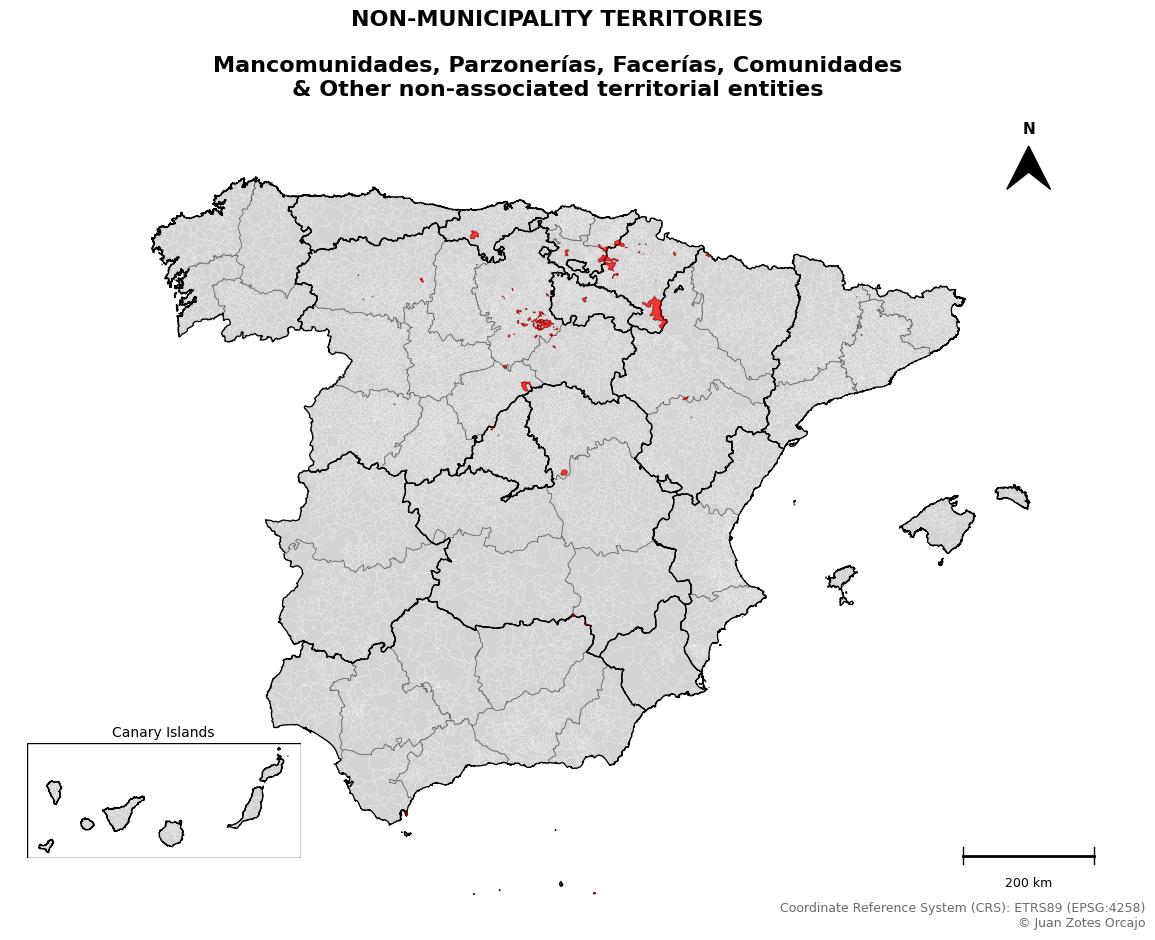

In [29]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as patches

# ==============================================================================
# MAP: Non-municipality territories (Peninsular focus + Canary Islands inset)
# ==============================================================================

fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# ------------------------------------------------------------------
# MAIN MAP (Peninsula + Ceuta/Melilla)
# ------------------------------------------------------------------

# Municipalities
gdf_mun.plot(
    ax=ax,
    color="lightgray",
    edgecolor="white",
    linewidth=0.1,
    zorder=1
)

# Provinces
gdf_prov.boundary.plot(
    ax=ax,
    linewidth=0.4,
    color="dimgray",
    zorder=2
)

# CCAA
gdf_ccaa.boundary.plot(
    ax=ax,
    linewidth=0.9,
    color="black",
    zorder=3
)

# Non-municipal territories
non_municipalities.plot(
    ax=ax,
    color="red",
    edgecolor="darkred",
    linewidth=0.6,
    alpha=0.75,
    zorder=4
)

# Title
fig.suptitle(
    "NON-MUNICIPALITY TERRITORIES\n\n"
    "Mancomunidades, Parzonerías, Facerías, Comunidades\n"
    "& Other non-associated territorial entities",
    fontsize=16,
    fontweight="bold",
    y=0.93
)

plt.subplots_adjust(top=0.77)

fig.text(
    0.99, 0.01,
    "Coordinate Reference System (CRS): ETRS89 (EPSG:4258)\n© Juan Zotes Orcajo",
    ha="right",
    va="bottom",
    fontsize=9,
    color="dimgray"
)
# ------------------------------------------------------------------
# North arrow (stylized, top-right)
# ------------------------------------------------------------------

# Coordinates in axes fraction
arrow_coords = [
    (0.93, 0.90),  # top
    (0.91, 0.85),  # left
    (0.93, 0.87),  # center notch
    (0.95, 0.85)   # right
]

north_arrow = patches.Polygon(
    arrow_coords,
    closed=True,
    transform=ax.transAxes,
    facecolor="black",
    edgecolor="black",
    zorder=10
)

ax.add_patch(north_arrow)

# "N" label
ax.text(
    0.93, 0.91,
    "N",
    transform=ax.transAxes,
    ha="center",
    va="bottom",
    fontsize=11,
    fontweight="bold",
    color="black"
)


# ------------------------------------------------------------------
# Scale bar (200 km, bottom-right, above CRS)
# ------------------------------------------------------------------

scale_text = "200 km"

# Position in axes fraction coordinates
x0, y0 = 0.87, 0.08      # start point
x1 = 0.99               # end point

# Main scale line
ax.plot(
    [x0, x1], [y0, y0],
    transform=ax.transAxes,
    color="black",
    linewidth=2,
    zorder=10
)

# End ticks
ax.plot([x0, x0], [y0 - 0.01, y0 + 0.01],
        transform=ax.transAxes, color="black", linewidth=1)
ax.plot([x1, x1], [y0 - 0.01, y0 + 0.01],
        transform=ax.transAxes, color="black", linewidth=1)

# Label
ax.text(
    (x0 + x1) / 2,
    y0 - 0.025,
    scale_text,
    transform=ax.transAxes,
    ha="center",
    va="top",
    fontsize=9,
    color="black"
)

# ------------------------------------------------------------------
# Peninsular extent (slightly zoomed out, Melilla-friendly)
# ------------------------------------------------------------------
ax.set_xlim(-11.5, 5.5)
ax.set_ylim(34.8, 45.2)

ax.set_axis_off()

# ------------------------------------------------------------------
# CANARY ISLANDS INSET (context, framed)
# ------------------------------------------------------------------

CANARIAS_CODE = "05"

canarias_mun = gdf_mun[gdf_mun["CCAA_Code"] == CANARIAS_CODE]
canarias_prov = gdf_prov[gdf_prov["CCAA_Code"] == CANARIAS_CODE]
canarias_ccaa = gdf_ccaa[gdf_ccaa["CCAA_Code"] == CANARIAS_CODE]

# Create inset (bottom-left, close to main map)
ax_inset = inset_axes(
    ax,
    width="25%",
    height="25%",
    loc="lower left",
    borderpad=1.2
)

# Plot Canary Islands (no non-municipal layer here)
canarias_mun.plot(
    ax=ax_inset,
    color="lightgray",
    edgecolor="white",
    linewidth=0.1
)

canarias_prov.boundary.plot(
    ax=ax_inset,
    linewidth=0.4,
    color="dimgray"
)

canarias_ccaa.boundary.plot(
    ax=ax_inset,
    linewidth=0.9,
    color="black"
)

ax_inset.set_title("Canary Islands", fontsize=10, pad=4)
ax_inset.set_axis_off()

# ------------------------------------------------------------------
# Frame around Canary Islands inset (cartographic convention)
# ------------------------------------------------------------------
rect = patches.Rectangle(
    (0, 0), 1, 1,
    transform=ax_inset.transAxes,
    linewidth=1.0,
    edgecolor="black",
    facecolor="none",
    zorder=10
)
ax_inset.add_patch(rect)

plt.tight_layout()
plt.show()




In [30]:
# EXCLUDE NON-MUNICIPALITY TERRITORIES FROM CNIG

# The CNIG shapefiles include territories that are NOT official municipalities
# according to INE (Instituto Nacional de Estadística).
#
# These include:
# 1. Codes >= 53000: Mancomunidades, parzonerías, facerías, comunidades
#    (shared land management entities between municipalities, NOT municipalities)
# 2. Code 54007: Isla de los Faisanes (Spanish-French condominium)
#
# Official INE count: 8,132 municipalities (as of January 1, 2026)
# Source: https://www.ine.es/en/prensa/np983_en.htm

print("\n" + "="*70)
print("FILTERING NON-MUNICIPALITY TERRITORIES")
print("="*70)

# Count before filtering
count_before = len(gdf_mun)

# Identify non-municipality territories (codes >= 53000)
non_municipalities = gdf_mun[gdf_mun['Mun_Code'].astype(int) >= 53000].copy()

print(f"\nTerritories to exclude (codes >= 53000):")
print(f"  Total: {len(non_municipalities)} records")
print(f"\n  Breakdown:")

# Categorize by type
mancomunidades = non_municipalities[non_municipalities['Mun_Code'].astype(int) < 54000]
otros = non_municipalities[non_municipalities['Mun_Code'].astype(int) >= 54000]

print(f"    - Mancomunidades/Parzonerías/Facerías/Comunidades (53xxx): {len(mancomunidades)}")
print(f"    - Other non-associated territories (54xxx): {len(otros)}")

if len(otros) > 0:
    print(f"\n  54xxx territories:")
    for _, row in otros.iterrows():
        print(f"    {int(row['Mun_Code']):05d} - {row['Mun_Name']}")

# Filter out non-municipality territories
gdf_mun = gdf_mun[gdf_mun['Mun_Code'].astype(int) < 53000].copy()
count_after = len(gdf_mun)

print(f"\n--- Filtering results ---")
print(f"   Before: {count_before}")
print(f"   Removed: {count_before - count_after}")
print(f"   After: {count_after}")

# Validate against official INE count
INE_OFFICIAL_COUNT = 8132

try:
    assert count_after == INE_OFFICIAL_COUNT, \
        f"Expected {INE_OFFICIAL_COUNT} municipalities (INE official), got {count_after}"
    print(f"\n✓ Municipality count matches INE official figure ({INE_OFFICIAL_COUNT})")
except AssertionError as e:
    print(f"\n⚠ {e}")
    diff = count_after - INE_OFFICIAL_COUNT
    if diff > 0:
        print(f"   → {diff} extra municipalities need investigation")
    else:
        print(f"   → {-diff} municipalities missing")


FILTERING NON-MUNICIPALITY TERRITORIES

Territories to exclude (codes >= 53000):
  Total: 88 records

  Breakdown:
    - Mancomunidades/Parzonerías/Facerías/Comunidades (53xxx): 81
    - Other non-associated territories (54xxx): 7

  54xxx territories:
    54007 - Isla de los Faisanes
    54006 - Gibraltar
    54001 - Isla del Perejil
    54002 - Peñón de Vélez de la Gomera
    54003 - Islas Chafarinas
    54004 - Islas Alhucemas
    54005 - Peñón de Alhucemas

--- Filtering results ---
   Before: 8220
   Removed: 88
   After: 8132

✓ Municipality count matches INE official figure (8132)


In [31]:
gdf_mun[['Mun_Code']].nunique()

Mun_Code    8132
dtype: int64

In [32]:
# ==============================================================================
# FINAL VALIDATION AGAINST OFFICIAL INE COUNTS
# ==============================================================================

print("\n" + "="*70)
print("FINAL VALIDATION AGAINST OFFICIAL INE COUNTS")
print("="*70)

# --- OFFICIAL INE COUNTS ---
INE_MUNICIPALITIES = 8132
INE_PROVINCES = 52
INE_CCAA = 19

# --- FINAL DATASET ---
# After filtering, gdf_mun contains ONLY official INE municipalities
df_final = gdf_mun

# --- SAFETY CHECK ---
required_cols = ["Mun_Code", "Prov_Code", "CCAA_Code"]
missing_cols = [c for c in required_cols if c not in df_final.columns]

if missing_cols:
    raise ValueError(f"Missing required columns in final dataset: {missing_cols}")

# --- COUNTS ---
count_mun = df_final["Mun_Code"].nunique()
count_prov = df_final["Prov_Code"].nunique()
count_ccaa = df_final["CCAA_Code"].nunique()

checks_passed = True

# --- MUNICIPALITIES ---
if count_mun == INE_MUNICIPALITIES:
    print(f"✓ Municipalities: {count_mun} (matches INE)")
else:
    print(f"✗ Municipalities: {count_mun} (expected {INE_MUNICIPALITIES})")
    checks_passed = False

# --- PROVINCES ---
if count_prov == INE_PROVINCES:
    print(f"✓ Provinces: {count_prov} (matches INE)")
else:
    print(f"✗ Provinces: {count_prov} (expected {INE_PROVINCES})")
    checks_passed = False

# --- CCAA ---
if count_ccaa == INE_CCAA:
    print(f"✓ CCAA: {count_ccaa} (matches INE)")
else:
    print(f"✗ CCAA: {count_ccaa} (expected {INE_CCAA})")
    checks_passed = False

# --- FINAL STATUS ---
if checks_passed:
    print("\n✓ All counts match official INE figures")
else:
    print("\n⚠ Some counts differ from INE — review cleaning steps")

# --- HARD ASSERTIONS (FAIL FAST) ---
assert count_mun == INE_MUNICIPALITIES, f"Municipality count mismatch: {count_mun}"
assert count_prov == INE_PROVINCES, f"Province count mismatch: {count_prov}"
assert count_ccaa == INE_CCAA, f"CCAA count mismatch: {count_ccaa}"

print("="*70)
print("✓ DATASET PASSES ALL INE CONSISTENCY CHECKS")
print("="*70)



FINAL VALIDATION AGAINST OFFICIAL INE COUNTS
✓ Municipalities: 8132 (matches INE)
✓ Provinces: 52 (matches INE)
✓ CCAA: 19 (matches INE)

✓ All counts match official INE figures
✓ DATASET PASSES ALL INE CONSISTENCY CHECKS


## 8. Build administrative hierarchy table

Using the lookup tables, we assign official province and CCAA names to each municipality
based on codes extracted from NATCODE.

In [33]:
# Start with municipality base data
hierarchy_df = gdf_mun[['Mun_Code', 'Mun_Name', 'CCAA_Code', 'Prov_Code']].copy()

print(f"Base table: {len(hierarchy_df)} municipalities")

Base table: 8132 municipalities


In [34]:
# Merge with province names
hierarchy_df = hierarchy_df.merge(
    prov_lookup[['CCAA_Code', 'Prov_Code', 'Prov_Name']],
    on=['CCAA_Code', 'Prov_Code'],
    how='left'
)

print(f"After province merge: {len(hierarchy_df)} records")
print(f"Municipalities without province name: {hierarchy_df['Prov_Name'].isna().sum()}")

After province merge: 8132 records
Municipalities without province name: 0


In [35]:
# Merge with CCAA names
hierarchy_df = hierarchy_df.merge(
    ccaa_lookup[['CCAA_Code', 'CCAA_Name']],
    on='CCAA_Code',
    how='left'
)

print(f"After CCAA merge: {len(hierarchy_df)} records")
print(f"Municipalities without CCAA name: {hierarchy_df['CCAA_Name'].isna().sum()}")

After CCAA merge: 8132 records
Municipalities without CCAA name: 0


In [36]:
# Verify no duplicates were created
duplicates = hierarchy_df[hierarchy_df.duplicated(subset=['Mun_Code'], keep=False)]
if len(duplicates) > 0:
    print(f"⚠ WARNING: {len(duplicates)} duplicate Mun_Code entries found")
    print(duplicates[['Mun_Code', 'Mun_Name', 'Prov_Name']].head(10))
else:
    print("✓ No duplicate municipalities")

# Display sample
print("\n=== Sample hierarchical data ===")
print(hierarchy_df.head(10))

✓ No duplicate municipalities

=== Sample hierarchical data ===
  Mun_Code                      Mun_Name CCAA_Code Prov_Code Prov_Name  \
0    09298        Quintanilla San García        07        09    Burgos   
1    09301             Quintanilla Vivar        07        09    Burgos   
2    09302            Rabanera del Pinar        07        09    Burgos   
3    05105              Hoyos del Espino        07        05     Ávila   
4    05106         Hoyos de Miguel Muñoz        07        05     Ávila   
5    05107                 Hurtumpascual        07        05     Ávila   
6    05108                      Junciana        07        05     Ávila   
7    05109                         Langa        07        05     Ávila   
8    05114  Madrigal de las Altas Torres        07        05     Ávila   
9    05116         Malpartida de Corneja        07        05     Ávila   

         CCAA_Name  
0  Castilla y León  
1  Castilla y León  
2  Castilla y León  
3  Castilla y León  
4  Castilla y Le

## 9. Add agricultural regions (comarcas agrarias) via spatial join

Agricultural regions are assigned via spatial join using municipality centroids.
This is optional - some municipalities may not have a comarca assigned.

**Note:** A few municipalities may fail the spatial join due to centroid placement issues.
These will be assigned manually in the next section.

In [37]:
# NOTE: This spatial join processes ALL entities in gdf_mun (8220)
# including the 88 territorial anomalies

# Perform spatial join with comarcas if available
if INCLUDE_COMARCAS:
    print("\n" + "="*70)
    print("ADDING AGRICULTURAL REGIONS (COMARCAS AGRARIAS)")
    print("="*70)
    
    # Identify comarca field names
    comarca_name_col = 'DS_COMARCA' if 'DS_COMARCA' in gdf_comarca.columns else 'NAMEUNIT'
    comarca_code_col = 'CO_COMARCA' if 'CO_COMARCA' in gdf_comarca.columns else None
    
    print(f"\nComarca fields identified:")
    print(f"  Name column: {comarca_name_col}")
    print(f"  Code column: {comarca_code_col}")
    
    # Compute municipality centroids
    print("\nComputing municipality centroids...")
    gdf_mun['centroid'] = gdf_mun.geometry.centroid
    gdf_mun_centroids = gdf_mun.set_geometry('centroid')
    
    # Prepare comarca data for spatial join
    select_cols = ['geometry', comarca_name_col]
    if comarca_code_col:
        select_cols.append(comarca_code_col)
    
    gdf_comarca_simple = gdf_comarca[select_cols].copy()
    
    # Rename for consistency
    rename_dict = {comarca_name_col: 'Comarca_Name'}
    if comarca_code_col:
        rename_dict[comarca_code_col] = 'Comarca_Code'
    gdf_comarca_simple = gdf_comarca_simple.rename(columns=rename_dict)
    
    # Spatial join
    print("Performing spatial join: Municipalities → Comarcas...")
    mun_comarca = gpd.sjoin(
        gdf_mun_centroids[['Mun_Code', 'centroid']],
        gdf_comarca_simple,
        how='left',
        predicate='within'
    )
    
    # Keep only relevant columns and remove duplicates
    keep_cols = ['Mun_Code', 'Comarca_Name']
    if 'Comarca_Code' in mun_comarca.columns:
        keep_cols.append('Comarca_Code')
    
    mun_comarca = mun_comarca[keep_cols].drop_duplicates(subset=['Mun_Code'])
    
    # Merge with hierarchy table
    hierarchy_df = hierarchy_df.merge(
        mun_comarca,
        on='Mun_Code',
        how='left'
    )
    
    print(f"\n✓ Comarca data added via spatial join")
    print(f"  Municipalities with comarca: {hierarchy_df['Comarca_Name'].notna().sum()}")
    print(f"  Municipalities without comarca: {hierarchy_df['Comarca_Name'].isna().sum()}")

else:
    print("\nSkipping comarca data (shapefile not found).")


ADDING AGRICULTURAL REGIONS (COMARCAS AGRARIAS)

Comarca fields identified:
  Name column: DS_COMARCA
  Code column: CO_COMARCA

Computing municipality centroids...
Performing spatial join: Municipalities → Comarcas...

✓ Comarca data added via spatial join
  Municipalities with comarca: 8127
  Municipalities without comarca: 5


## 10. Manual comarca assignment for edge cases

Some municipalities fail the spatial join due to:
- Centroid falling outside comarca boundaries (irregular shapes)
- Small coastal municipalities
- Autonomous cities (Ceuta, Melilla) - these have no comarca by design

We manually assign comarcas to the affected municipalities.

In [38]:
rename_dict = {
    'DS_COMARCA': 'Comarca_Name',
    'CO_COMARCA': 'Comarca_Code'
}


In [39]:
# Analyze municipalities without comarca assignment
if INCLUDE_COMARCAS:
    missing_comarca = hierarchy_df[hierarchy_df['Comarca_Name'].isna()].copy()
    
    if len(missing_comarca) > 0:
        print("\n" + "="*70)
        print("MUNICIPALITIES WITHOUT COMARCA ASSIGNMENT")
        print("="*70)
        
        print(f"\nTotal: {len(missing_comarca)} municipalities")
        print("\nList:")
        for _, row in missing_comarca.iterrows():
            print(f"  {row['Mun_Code']} - {row['Mun_Name']:40s} | {row['Prov_Name']}")
    else:
        print("\n✓ All municipalities have comarca assignment")


MUNICIPALITIES WITHOUT COMARCA ASSIGNMENT

Total: 5 municipalities

List:
  25239 - Les Valls de Valira                      | Lleida
  43136 - La Ràpita                                | Tarragona
  51001 - Ceuta                                    | Ceuta
  52001 - Melilla                                  | Melilla
  35015 - Pájara                                   | Las Palmas


In [40]:
# Assign comarca to municipalities without one, using area intersection
if INCLUDE_COMARCAS and 'Comarca_Name' in hierarchy_df.columns:
    missing_comarca = hierarchy_df[hierarchy_df['Comarca_Name'].isna()].copy()
    
    if len(missing_comarca) > 0:
        print("\n" + "="*70)
        print("ASSIGNING COMARCAS BY AREA INTERSECTION")
        print("="*70)
        
        assigned_count = 0
        
        for idx, mun_row in missing_comarca.iterrows():
            mun_code = mun_row['Mun_Code']
            
            # Get municipality geometry from gdf_mun
            mun_geom = gdf_mun[gdf_mun['Mun_Code'] == mun_code].geometry.iloc[0]
            
            # Find all comarcas that intersect with this municipality
            intersecting = gdf_comarca[gdf_comarca.intersects(mun_geom)].copy()
            
            if len(intersecting) > 0:
                # Calculate intersection area for each comarca
                intersecting['intersection_area'] = intersecting.geometry.apply(
                    lambda x: mun_geom.intersection(x).area
                )
                
                # Get the comarca with maximum intersection area
                max_idx = intersecting['intersection_area'].idxmax()
                best_comarca = intersecting.loc[max_idx]
                
                comarca_code = best_comarca['Comarca_Code']
                comarca_name = best_comarca['Comarca_Name']
                
                # Assign to hierarchy_df
                hierarchy_df.loc[hierarchy_df['Mun_Code'] == mun_code, 'Comarca_Code'] = comarca_code
                hierarchy_df.loc[hierarchy_df['Mun_Code'] == mun_code, 'Comarca_Name'] = comarca_name
                
                print(f"  ✓ {mun_code} - {mun_row['Mun_Name']:35s} → {comarca_name}")
                assigned_count += 1
            else:
                # No intersection found - leave as NaN
                print(f"  ○ {mun_code} - {mun_row['Mun_Name']:35s} → No comarca (no intersection)")
        
        print(f"\n--- Results ---")
        print(f"  Assigned: {assigned_count}")
        print(f"  Remaining without comarca: {hierarchy_df['Comarca_Name'].isna().sum()}")
        
        # Show final municipalities without comarca (should be Ceuta, Melilla, or small islands)
        still_missing = hierarchy_df[hierarchy_df['Comarca_Name'].isna()]
        if len(still_missing) > 0:
            print(f"\n  Final municipalities without comarca (expected: Ceuta, Melilla):")
            for _, row in still_missing.iterrows():
                print(f"    {row['Mun_Code']} - {row['Mun_Name']} ({row['Prov_Name']})")
    else:
        print("\n✓ All municipalities already have comarca assignment")
else:
    print("\nSkipping comarca assignment (INCLUDE_COMARCAS = False)")


ASSIGNING COMARCAS BY AREA INTERSECTION
  ✓ 25239 - Les Valls de Valira                 → ALT URGELL
  ✓ 43136 - La Ràpita                           → MONTSIA
  ✓ 51001 - Ceuta                               → nan
  ✓ 52001 - Melilla                             → nan
  ✓ 35015 - Pájara                              → FUERTEVENTURA

--- Results ---
  Assigned: 5
  Remaining without comarca: 2

  Final municipalities without comarca (expected: Ceuta, Melilla):
    51001 - Ceuta (Ceuta)
    52001 - Melilla (Melilla)


## 10.5. Export territorial anomalies with comarca enrichment

Now that we have completed the spatial join with comarcas (including manual assignments),
we export all territorial anomalies (codes >= 53000) before filtering the dataset.

**Key enrichment for 53xxx anomalies:**
- Shared land entities (53xxx) have NATCODE with no valid Prov/CCAA codes
- BUT if they were assigned a comarca via spatial join, we can derive their Prov/CCAA
- We use the comarca lookup table to backfill Prov_Code, Prov_Name, CCAA_Code, CCAA_Name

**For 54xxx territories:**
- These are special territories outside administrative structure
- They will have no comarca (expected)
- Their Prov/CCAA fields remain as-is (typically "Territorios no asociados")

**Files generated:**
- `territorial_anomalies.csv` - All columns from gdf_mun + enriched admin data
- `territorial_anomalies.gpkg` - Full spatial layer with all attributes

In [41]:
print(f"gdf_mun tiene: {len(gdf_mun)} entidades")
print(f"Anomalías (>=53000): {len(gdf_mun[gdf_mun['Mun_Code'].astype(int) >= 53000])}")

gdf_mun tiene: 8132 entidades
Anomalías (>=53000): 0


In [42]:
# ==============================================================================
# EXTRACT AND ENRICH TERRITORIAL ANOMALIES
# ==============================================================================

print("\n" + "="*70)
print("EXTRACTING TERRITORIAL ANOMALIES")
print("="*70)

# Use the non_municipalities variable created earlier (before filtering)
gdf_anomalies = non_municipalities.copy()

print(f"\nTotal anomalies extracted: {len(gdf_anomalies)}")
print(f"  - Shared land (53xxx): {len(gdf_anomalies[gdf_anomalies['Mun_Code'].astype(int) < 54000])}")
print(f"  - Special territories (54xxx): {len(gdf_anomalies[gdf_anomalies['Mun_Code'].astype(int) >= 54000])}")

# Add anomaly type classification
def classify_anomaly(code):
    code_int = int(code)
    if 53000 <= code_int < 54000:
        return 'Shared_Land'
    elif code_int >= 54000:
        return 'Special_Territory'
    return 'Unknown'

gdf_anomalies['Anomaly_Type'] = gdf_anomalies['Mun_Code'].apply(classify_anomaly)

# Add Admin_Status column for territorial context
def classify_admin_status(code):
    code_int = int(code)
    if code_int < 53000:
        return 'Normal'
    elif 53000 <= code_int < 54000:
        return 'Shared_Land'
    elif code_int == 54007:
        return 'Condominio_Hispano-Frances'
    elif code_int == 54006:
        return 'Territorio_Extranjero'
    elif 54001 <= code_int <= 54005:
        return 'Plaza_Soberania'
    return 'Unknown'

gdf_anomalies['Admin_Status'] = gdf_anomalies['Mun_Code'].apply(classify_admin_status)

# Store original administrative codes
gdf_anomalies['Prov_Code_Original'] = gdf_anomalies['Prov_Code'].copy()
gdf_anomalies['CCAA_Code_Original'] = gdf_anomalies['CCAA_Code'].copy()

# ==============================================================================
# SPATIAL JOIN: ANOMALIES → COMARCAS
# ==============================================================================

if INCLUDE_COMARCAS and gdf_comarca is not None:
    print("\n" + "="*70)
    print("SPATIAL JOIN: ANOMALIES → COMARCAS")
    print("="*70)
    
    # Prepare comarca data
    comarca_name_col = 'DS_COMARCA' if 'DS_COMARCA' in gdf_comarca.columns else 'NAMEUNIT'
    comarca_code_col = 'CO_COMARCA' if 'CO_COMARCA' in gdf_comarca.columns else None
    
    select_cols = ['geometry', comarca_name_col]
    if comarca_code_col:
        select_cols.append(comarca_code_col)
    
    gdf_comarca_simple = gdf_comarca[select_cols].copy()
    rename_dict = {comarca_name_col: 'Comarca_Name'}
    if comarca_code_col:
        rename_dict[comarca_code_col] = 'Comarca_Code'
    gdf_comarca_simple = gdf_comarca_simple.rename(columns=rename_dict)
    
    # METHOD 1: Centroid-based spatial join
    print("\n1. Attempting centroid-based spatial join...")
    gdf_anomalies['centroid'] = gdf_anomalies.geometry.centroid
    gdf_anomalies_centroids = gdf_anomalies.set_geometry('centroid')
    
    anomalies_with_comarca = gpd.sjoin(
        gdf_anomalies_centroids[['Mun_Code', 'centroid']],
        gdf_comarca_simple,
        how='left',
        predicate='within'
    )
    
    keep_cols = ['Mun_Code', 'Comarca_Name']
    if 'Comarca_Code' in anomalies_with_comarca.columns:
        keep_cols.append('Comarca_Code')
    
    anomalies_with_comarca = anomalies_with_comarca[keep_cols].drop_duplicates(subset=['Mun_Code'])
    
    gdf_anomalies = gdf_anomalies.merge(
        anomalies_with_comarca,
        on='Mun_Code',
        how='left'
    )
    gdf_anomalies = gdf_anomalies.drop(columns=['centroid'])
    
    centroid_assigned = gdf_anomalies['Comarca_Name'].notna().sum()
    print(f"   Assigned via centroid: {centroid_assigned}/{len(gdf_anomalies)}")
    
    # METHOD 2: Area intersection for remaining
    still_missing = gdf_anomalies['Comarca_Name'].isna().sum()
    
    if still_missing > 0:
        print(f"\n2. Using area intersection for remaining {still_missing} anomalies...")
        assigned_by_area = 0
        
        for idx, row in gdf_anomalies[gdf_anomalies['Comarca_Name'].isna()].iterrows():
            mun_geom = row['geometry']
            intersecting = gdf_comarca_simple[gdf_comarca_simple.intersects(mun_geom)].copy()
            
            if len(intersecting) > 0:
                intersecting['intersection_area'] = intersecting.geometry.apply(
                    lambda x: mun_geom.intersection(x).area
                )
                max_idx = intersecting['intersection_area'].idxmax()
                best_comarca = intersecting.loc[max_idx]
                
                gdf_anomalies.at[idx, 'Comarca_Name'] = best_comarca['Comarca_Name']
                if 'Comarca_Code' in best_comarca.index:
                    gdf_anomalies.at[idx, 'Comarca_Code'] = best_comarca['Comarca_Code']
                assigned_by_area += 1
        
        print(f"   Assigned via area intersection: {assigned_by_area}")
    
    total_with_comarca = gdf_anomalies['Comarca_Name'].notna().sum()
    total_without_comarca = gdf_anomalies['Comarca_Name'].isna().sum()
    
    print(f"\n--- Spatial join results ---")
    print(f"  Total with comarca: {total_with_comarca}/{len(gdf_anomalies)}")
    print(f"  Total without comarca: {total_without_comarca}")
    
    for atype in gdf_anomalies['Anomaly_Type'].unique():
        subset = gdf_anomalies[gdf_anomalies['Anomaly_Type'] == atype]
        with_c = subset['Comarca_Name'].notna().sum()
        print(f"    {atype}: {with_c}/{len(subset)} with comarca")
    
    # ==============================================================================
    # BUILD COMARCA → PROV/CCAA LOOKUP
    # ==============================================================================
    
    if total_with_comarca > 0 and 'Comarca_Name' in hierarchy_df.columns:
        print("\n" + "="*70)
        print("BUILDING COMARCA → PROV/CCAA LOOKUP")
        print("="*70)
        
        mun_with_comarca = hierarchy_df[
            hierarchy_df['Comarca_Name'].notna()
        ][['Comarca_Code', 'Comarca_Name', 'Prov_Code', 'CCAA_Code']].copy()
        
        comarca_to_admin = mun_with_comarca.groupby(
            ['Comarca_Code', 'Comarca_Name']
        ).agg({
            'Prov_Code': lambda x: x.mode()[0] if not x.mode().empty else x.iloc[0],
            'CCAA_Code': lambda x: x.mode()[0] if not x.mode().empty else x.iloc[0]
        }).reset_index()
        
        print(f"\n  Built lookup: {len(comarca_to_admin)} comarcas")
        print(f"  Sample:")
        print(comarca_to_admin.head(3).to_string(index=False))
        
        # ==============================================================================
        # ENRICH 53xxx: DERIVE PROV/CCAA FROM COMARCA
        # ==============================================================================
        
        print("\n" + "="*70)
        print("ENRICHING 53xxx ANOMALIES")
        print("="*70)
        
        mask_53xxx_with_comarca = (
            (gdf_anomalies['Mun_Code'].astype(int) >= 53000) & 
            (gdf_anomalies['Mun_Code'].astype(int) < 54000) &
            (gdf_anomalies['Comarca_Name'].notna())
        )
        
        enrichable = mask_53xxx_with_comarca.sum()
        print(f"\n  Found {enrichable} shared land entities with comarca")
        
        if enrichable > 0:
            # Merge to get Prov/CCAA codes from comarca
            gdf_anomalies = gdf_anomalies.merge(
                comarca_to_admin[['Comarca_Code', 'Prov_Code', 'CCAA_Code']],
                on='Comarca_Code',
                how='left',
                suffixes=('', '_from_comarca')
            )
            
            # Update only 53xxx that have comarca AND valid derived codes
            if 'Prov_Code_from_comarca' in gdf_anomalies.columns:
                # Create mask for rows that have BOTH comarca AND valid derived codes
                mask_with_valid_codes = (
                    mask_53xxx_with_comarca & 
                    gdf_anomalies['Prov_Code_from_comarca'].notna()
                )
                
                # Update only those rows
                gdf_anomalies.loc[mask_with_valid_codes, 'Prov_Code'] = \
                    gdf_anomalies.loc[mask_with_valid_codes, 'Prov_Code_from_comarca']
                gdf_anomalies.loc[mask_with_valid_codes, 'CCAA_Code'] = \
                    gdf_anomalies.loc[mask_with_valid_codes, 'CCAA_Code_from_comarca']
                
                actually_updated = mask_with_valid_codes.sum()
                print(f"  ✓ Updated {actually_updated} entities with valid comarca-derived codes")
                
                # Drop temporary columns
                gdf_anomalies = gdf_anomalies.drop(
                    columns=['Prov_Code_from_comarca', 'CCAA_Code_from_comarca']
                )
            
            print(f"  ✓ Codes updated for entities with valid comarca lookup")
            
            # Add names via lookups
            print("\n  Adding province and CCAA names...")
            
            gdf_anomalies = gdf_anomalies.merge(
                prov_lookup[['Prov_Code', 'Prov_Name']].drop_duplicates(),
                on='Prov_Code',
                how='left',
                suffixes=('', '_new')
            )
            
            if 'Prov_Name_new' in gdf_anomalies.columns:
                # For rows that now have enriched data, use it
                mask_enriched = gdf_anomalies['Prov_Name_new'].notna()
                gdf_anomalies.loc[mask_enriched, 'Prov_Name'] = gdf_anomalies.loc[mask_enriched, 'Prov_Name_new']
                gdf_anomalies = gdf_anomalies.drop(columns=['Prov_Name_new'])
            
            gdf_anomalies = gdf_anomalies.merge(
                ccaa_lookup[['CCAA_Code', 'CCAA_Name']].drop_duplicates(),
                on='CCAA_Code',
                how='left',
                suffixes=('', '_new')
            )
            
            if 'CCAA_Name_new' in gdf_anomalies.columns:
                mask_enriched = gdf_anomalies['CCAA_Name_new'].notna()
                gdf_anomalies.loc[mask_enriched, 'CCAA_Name'] = gdf_anomalies.loc[mask_enriched, 'CCAA_Name_new']
                gdf_anomalies = gdf_anomalies.drop(columns=['CCAA_Name_new'])
            
            print(f"  ✓ Added names for enriched entities")

else:
    print("\nSkipping comarca enrichment (INCLUDE_COMARCAS = False)")
    gdf_anomalies['Comarca_Code'] = None
    gdf_anomalies['Comarca_Name'] = None

# ==============================================================================
# ENRICH 54xxx: SPECIAL TERRITORIAL ASSIGNMENTS
# ==============================================================================

print("\n" + "="*70)
print("ENRICHING 54xxx SPECIAL TERRITORIES")
print("="*70)

# Define specific assignments based on Admin_Status
special_assignments = {
    # Plazas de Soberanía → Melilla (administrative dependency)
    '54001': {'Prov_Code': '52', 'CCAA_Code': '19', 'reason': 'Plaza de Soberanía (Capitanía Marítima de Melilla)'},
    '54002': {'Prov_Code': '52', 'CCAA_Code': '19', 'reason': 'Plaza de Soberanía (Capitanía Marítima de Melilla)'},
    '54003': {'Prov_Code': '52', 'CCAA_Code': '19', 'reason': 'Plaza de Soberanía (Capitanía Marítima de Melilla)'},
    '54004': {'Prov_Code': '52', 'CCAA_Code': '19', 'reason': 'Plaza de Soberanía (Capitanía Marítima de Melilla)'},
    '54005': {'Prov_Code': '52', 'CCAA_Code': '19', 'reason': 'Plaza de Soberanía (Capitanía Marítima de Melilla)'},
    
    # Gibraltar → Reino Unido (keep NaN for Spanish admin)
    '54006': {'Prov_Code': None, 'CCAA_Code': None, 'reason': 'Territorio Británico (no jurisdicción española)'},
    
    # Isla de los Faisanes → Condominio (assign to Gipuzkoa for geographic reference)
    '54007': {'Prov_Code': '20', 'CCAA_Code': '16', 'reason': 'Condominio Hispano-Francés (ubicación: Gipuzkoa)'}
}

print(f"\n  Applying specific assignments for {len(special_assignments)} special territories:")

for territory_code, assignment in special_assignments.items():
    if territory_code in gdf_anomalies['Mun_Code'].values:
        idx = gdf_anomalies[gdf_anomalies['Mun_Code'] == territory_code].index[0]
        territory_name = gdf_anomalies.loc[idx, 'Mun_Name']
        
        print(f"\n  • {territory_code} - {territory_name}")
        print(f"    Status: {gdf_anomalies.loc[idx, 'Admin_Status']}")
        print(f"    Reason: {assignment['reason']}")
        
        # Assign codes
        if assignment['Prov_Code'] is not None:
            gdf_anomalies.at[idx, 'Prov_Code'] = assignment['Prov_Code']
            gdf_anomalies.at[idx, 'CCAA_Code'] = assignment['CCAA_Code']
            
            # Get names from lookups
            prov_info = prov_lookup[prov_lookup['Prov_Code'] == assignment['Prov_Code']]
            ccaa_info = ccaa_lookup[ccaa_lookup['CCAA_Code'] == assignment['CCAA_Code']]
            
            if len(prov_info) > 0:
                gdf_anomalies.at[idx, 'Prov_Name'] = prov_info.iloc[0]['Prov_Name']
            if len(ccaa_info) > 0:
                gdf_anomalies.at[idx, 'CCAA_Name'] = ccaa_info.iloc[0]['CCAA_Name']
            
            print(f"    → Assigned: {gdf_anomalies.loc[idx, 'Prov_Name']}, {gdf_anomalies.loc[idx, 'CCAA_Name']}")
        else:
            # Keep as NaN (no Spanish jurisdiction)
            gdf_anomalies.at[idx, 'Prov_Code'] = None
            gdf_anomalies.at[idx, 'CCAA_Code'] = None
            gdf_anomalies.at[idx, 'Prov_Name'] = None
            gdf_anomalies.at[idx, 'CCAA_Name'] = None
            print(f"    → No Spanish jurisdiction (NaN)")

print("\n" + "="*70)
print(f"✓ Anomalies prepared for export: {len(gdf_anomalies)} entities")
print("="*70)

# Summary by Admin_Status
print(f"\n--- Summary by Admin_Status ---")
for status in gdf_anomalies['Admin_Status'].unique():
    count = (gdf_anomalies['Admin_Status'] == status).sum()
    print(f"  {status}: {count}")


EXTRACTING TERRITORIAL ANOMALIES

Total anomalies extracted: 88
  - Shared land (53xxx): 81
  - Special territories (54xxx): 7

SPATIAL JOIN: ANOMALIES → COMARCAS

1. Attempting centroid-based spatial join...
   Assigned via centroid: 82/88

2. Using area intersection for remaining 6 anomalies...
   Assigned via area intersection: 5

--- Spatial join results ---
  Total with comarca: 83/88
  Total without comarca: 5
    Shared_Land: 81/81 with comarca
    Special_Territory: 2/7 with comarca

BUILDING COMARCA → PROV/CCAA LOOKUP

  Built lookup: 352 comarcas
  Sample:
 Comarca_Code         Comarca_Name Prov_Code CCAA_Code
        101.0           CANTABRICA        01        16
        102.0 ESTRIBACIONES GORBEA        01        16
        103.0      VALLES ALAVESES        01        16

ENRICHING 53xxx ANOMALIES

  Found 81 shared land entities with comarca
  ✓ Updated 81 entities with valid comarca-derived codes
  ✓ Codes updated for entities with valid comarca lookup

  Adding province 

In [43]:
# Spatial data directory
SPATIAL_DIR_DER = Path(
    r"/workspaces/rural-migration-land-use-spain/data/spatial/derived")
# ==============================================================================
# EXPORT ANOMALIES TO CSV
# ==============================================================================

print("\n" + "="*70)
print("EXPORTING TERRITORIAL ANOMALIES")
print("="*70)

# Prepare dataframe for CSV export (convert geometry to WKT)
df_anomalies_export = gdf_anomalies.copy()
df_anomalies_export['geometry_wkt'] = df_anomalies_export['geometry'].apply(
    lambda x: x.wkt if x else None
)
df_anomalies_csv = df_anomalies_export.drop(columns=['geometry'])

# Export to CSV
csv_output = SPATIAL_DIR_DER / "territorial_anomalies.csv"
df_anomalies_csv.to_csv(csv_output, index=False)

print(f"\n✓ CSV exported to: {csv_output}")
print(f"  Records: {len(df_anomalies_csv)}")
print(f"  Columns: {len(df_anomalies_csv.columns)}")


EXPORTING TERRITORIAL ANOMALIES

✓ CSV exported to: /workspaces/rural-migration-land-use-spain/data/spatial/derived/territorial_anomalies.csv
  Records: 105
  Columns: 24


In [44]:
# ==============================================================================
# EXPORT ANOMALIES TO GEOPACKAGE
# ==============================================================================

# Export GeoDataFrame to GeoPackage
gpkg_output = SPATIAL_DIR_DER / "territorial_anomalies.gpkg"
gdf_anomalies.to_file(gpkg_output, driver='GPKG', layer='territorial_anomalies')

print(f"\n✓ GeoPackage exported to: {gpkg_output}")
print(f"  Layer: territorial_anomalies")
print(f"  Features: {len(gdf_anomalies)}")
print(f"  CRS: {gdf_anomalies.crs.to_string() if gdf_anomalies.crs else 'No CRS'}")


✓ GeoPackage exported to: /workspaces/rural-migration-land-use-spain/data/spatial/derived/territorial_anomalies.gpkg
  Layer: territorial_anomalies
  Features: 105
  CRS: EPSG:4258


## 11. Finalize column order and data types

Organize columns in hierarchical order and ensure proper data types.

In [45]:
# Define final column order (hierarchical: Mun → Comarca → Prov → CCAA)
final_columns = [
    'Mun_Code',
    'Mun_Name',
    'Prov_Code',
    'Prov_Name',
    'CCAA_Code',
    'CCAA_Name'
]

# Add comarca columns if available
if INCLUDE_COMARCAS:
    if 'Comarca_Code' in hierarchy_df.columns:
        final_columns.insert(2, 'Comarca_Code')
        final_columns.insert(3, 'Comarca_Name')
    elif 'Comarca_Name' in hierarchy_df.columns:
        final_columns.insert(2, 'Comarca_Name')

# Select and reorder columns
hierarchy_final = hierarchy_df[final_columns].copy()

# Ensure proper data types with leading zeros preserved
hierarchy_final['Mun_Code'] = hierarchy_final['Mun_Code'].astype(str).str.zfill(5)
hierarchy_final['Prov_Code'] = hierarchy_final['Prov_Code'].astype(str).str.zfill(2)
hierarchy_final['CCAA_Code'] = hierarchy_final['CCAA_Code'].astype(str).str.zfill(2)

print("Final table structure:")
hierarchy_final.info()

Final table structure:
<class 'pandas.DataFrame'>
RangeIndex: 8132 entries, 0 to 8131
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Mun_Code      8132 non-null   str    
 1   Mun_Name      8132 non-null   str    
 2   Comarca_Code  8132 non-null   float64
 3   Comarca_Name  8130 non-null   str    
 4   Prov_Code     8132 non-null   str    
 5   Prov_Name     8132 non-null   str    
 6   CCAA_Code     8132 non-null   str    
 7   CCAA_Name     8132 non-null   str    
dtypes: float64(1), str(7)
memory usage: 508.4 KB


In [46]:
# Display sample
print("\n=== Sample of final hierarchical data ===")
print(hierarchy_final.head(10))


=== Sample of final hierarchical data ===
  Mun_Code                      Mun_Name  Comarca_Code  \
0    09298        Quintanilla San García         902.0   
1    09301             Quintanilla Vivar         908.0   
2    09302            Rabanera del Pinar         903.0   
3    05105              Hoyos del Espino         504.0   
4    05106         Hoyos de Miguel Muñoz         504.0   
5    05107                 Hurtumpascual         502.0   
6    05108                      Junciana         503.0   
7    05109                         Langa         501.0   
8    05114  Madrigal de las Altas Torres         501.0   
9    05116         Malpartida de Corneja         503.0   

             Comarca_Name Prov_Code Prov_Name CCAA_Code        CCAA_Name  
0             BUREBA-EBRO        09    Burgos        07  Castilla y León  
1                ARLANZON        09    Burgos        07  Castilla y León  
2                 DEMANDA        09    Burgos        07  Castilla y León  
3                 

## 12. Export administrative hierarchy table

Export the complete administrative hierarchy as a CSV file.

In [47]:
# Export to CSV
output_file = SPATIAL_DIR_DER / "geographic_administrative_hierarchy.csv"

hierarchy_final.to_csv(output_file, index=False)

print(f"✓ Administrative hierarchy table exported to:")
print(f"  {output_file}")
print(f"\nFinal dataset: {len(hierarchy_final)} municipalities")

✓ Administrative hierarchy table exported to:
  /workspaces/rural-migration-land-use-spain/data/spatial/derived/geographic_administrative_hierarchy.csv

Final dataset: 8132 municipalities


In [48]:
# ==============================================================================
# EXPORT GEOPACKAGE WITH GEOMETRIES
# ==============================================================================

print("\n" + "="*70)
print("EXPORTING GEOPACKAGE")
print("="*70)

# Merge hierarchy data with geometries from gdf_mun
gdf_hierarchy = gdf_mun[gdf_mun['Mun_Code'].astype(int) < 53000].copy()

# Merge with hierarchy_final to get all administrative data
gdf_hierarchy = gdf_hierarchy.merge(
    hierarchy_final[['Mun_Code', 'Comarca_Code', 'Comarca_Name', 'Prov_Name', 'CCAA_Name']],
    on='Mun_Code',
    how='left'
)

# Select columns for export
export_columns = [
    'Mun_Code',
    'Mun_Name',
    'Comarca_Code',
    'Comarca_Name',
    'Prov_Code',
    'Prov_Name',
    'CCAA_Code',
    'CCAA_Name',
    'NATCODE',
    'geometry'
]

# Keep only relevant columns
available_columns = [col for col in export_columns if col in gdf_hierarchy.columns]
gdf_export = gdf_hierarchy[available_columns].copy()

# Export to GeoPackage
output_gpkg = SPATIAL_DIR / "derived" / "geographic_administrative_hierarchy.gpkg"

# Create derived directory if it doesn't exist
output_gpkg.parent.mkdir(parents=True, exist_ok=True)

# Export
gdf_export.to_file(
    output_gpkg,
    driver='GPKG',
    layer='municipalities'
)

print(f"\n✓ GeoPackage exported to:")
print(f"  {output_gpkg}")
print(f"  Layer: municipalities")
print(f"  Features: {len(gdf_export)}")
print(f"  CRS: {gdf_export.crs.to_string()}")
print(f"  Columns: {', '.join(gdf_export.columns.tolist())}")
print(f"\n  File size: {output_gpkg.stat().st_size / 1024 / 1024:.2f} MB")


EXPORTING GEOPACKAGE

✓ GeoPackage exported to:
  /workspaces/rural-migration-land-use-spain/data/spatial/raw/derived/geographic_administrative_hierarchy.gpkg
  Layer: municipalities
  Features: 8132
  CRS: EPSG:4258
  Columns: Mun_Code, Mun_Name, Comarca_Code, Comarca_Name, Prov_Code, Prov_Name, CCAA_Code, CCAA_Name, NATCODE, geometry

  File size: 70.61 MB


In [49]:
# Final verification
print("\n" + "="*70)
print("FINAL VERIFICATION")
print("="*70)

print(f"\n=== Summary statistics ===")
print(f"  Total municipalities: {len(hierarchy_final)}")
print(f"  Unique provinces: {hierarchy_final['Prov_Code'].nunique()}")
print(f"  Unique CCAA: {hierarchy_final['CCAA_Code'].nunique()}")

if INCLUDE_COMARCAS and 'Comarca_Name' in hierarchy_final.columns:
    print(f"  Unique comarcas: {hierarchy_final['Comarca_Name'].nunique()}")
    print(f"  Municipalities with comarca: {hierarchy_final['Comarca_Name'].notna().sum()}")
    print(f"  Municipalities without comarca: {hierarchy_final['Comarca_Name'].isna().sum()}")
    
    # Show which municipalities don't have comarca
    missing_comarca = hierarchy_final[hierarchy_final['Comarca_Name'].isna()]
    if len(missing_comarca) > 0:
        with_comarca = hierarchy_final['Comarca_Name'].notna().sum()
        without_comarca = len(missing_comarca)
        for _, row in missing_comarca.iterrows():
            print(f"    • {row['Mun_Code']} - {row['Mun_Name']} ({row['Prov_Name']})")

# Final assertion
assert len(hierarchy_final) == 8132, f"Final count mismatch: {len(hierarchy_final)} vs 8132"
print(f"\n✓ All checks passed. Dataset ready for use.")


FINAL VERIFICATION

=== Summary statistics ===
  Total municipalities: 8132
  Unique provinces: 52
  Unique CCAA: 19
  Unique comarcas: 335
  Municipalities with comarca: 8130
  Municipalities without comarca: 2
    • 51001 - Ceuta (Ceuta)
    • 52001 - Melilla (Melilla)

✓ All checks passed. Dataset ready for use.
